In [1]:
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
warnings.filterwarnings("ignore",category=UserWarning)

In [2]:
import numpy as np
import sqlalchemy
import matplotlib.pyplot as plt
import math
import seaborn as sns
from collections import Counter
import spectral_entropy
from scipy.spatial import distance
from scipy.cluster import hierarchy
from collections import Counter
from scipy.stats import entropy

In [3]:
database_address='../../data/database/bucketbase.db'

In [4]:
def execute_query(database_addres,query_string):
    '''
    
    '''
    engine=sqlalchemy.create_engine(f"sqlite:///{database_address}")
    connection=engine.connect()

    temp_cursor=connection.execute(
        query_string
    )

    temp_result=temp_cursor.fetchall()
    #print(temp_result)
    #print(f'we have this many associated spectra {len(temp_result)}')
    #print(len(temp_result))
    
    connection.close()
    engine.dispose()
    #print(len(temp_result))

    if len(temp_result)==0:
        return -1
    elif len(temp_result)>1:
        #print('here')
        return temp_result



In [5]:
def parse_one_ms_dial_spectrum(spectrum_text):
    '''
    takes an ms/ms spectrum as a string and returns a tuple of parallel lists?
    '''
    mz_int_pair_list=spectrum_text.split(' ')
    mz_list=[float(temp_pair.split(':')[0]) for temp_pair in mz_int_pair_list]
    intensity_list=[float(temp_pair.split(':')[1]) for temp_pair in mz_int_pair_list]
    
    return np.array([
        mz_list,
        intensity_list
    ])

In [6]:
def convert_np_spectrum_to_text(spectrum_array):
    '''
    takes an ms/ms spectrum in our numpy array format and converts it to string
    '''
    string_rep=[
        str(spectrum_array[0][i])+':'+str(spectrum_array[1][i]) for i in range(len(spectrum_array[0]))
    ]
    return ' '.join(string_rep)

In [7]:
def plot_some_head_to_tails(spectra,temp_axis,is_consensus=False):
    '''
    expects a list of spectra
    in the outer list, each spectrum is an element
    within each of those elements, the 0th element is an array of mz and teh 1th is array of intensities
    '''
    
    for spectrum in spectra:
        #print(spectrum)
        if is_consensus==False:
            temp_axis.stem(spectrum[0],spectrum[1])
        else:
            temp_axis.stem(spectrum[0],-1*spectrum[1])
    

In [8]:
def make_spectra_like_similarity_metric_expects(spectra):
    '''
    converts an array of parallel mz and intensity into pairs of mz,intensity
    '''
    output_list=list()
    for spectrum in spectra:
        #print(spectrum)
        output_list.append(np.column_stack(spectrum))
        #print(output_list)
        #hold=input('hold')
    return output_list

In [9]:
def get_list_of_bin_id_with_spectra():
    query='''SELECT bin_id,count(*)
    from annotations a
    where (spectrum is not null)
    group by bin_id
    '''
    spectrum_population_data=execute_query(database_address,query)
    #bin_ids=[element[0] for element in spectrum_population_data]
    #populations=[element[1] for element in spectrum_population_data]
    
    bin_id_sorted_by_pop=[
        x for x,_ in sorted(spectrum_population_data, key=lambda pair: pair[1],reverse=True)
    ]
    populations_sorted_by_pop=[
        x for _,x in sorted(spectrum_population_data, key=lambda pair: pair[1],reverse=True)
    ]
    #print(bin_id_sorted_by_pop)
    #print(populations_sorted_by_pop)
    return(bin_id_sorted_by_pop)

In [10]:
def make_spectra_like_head_to_tails_expects(spectra):
    '''
    converts an array of parallel mz and intensity into pairs of mz,intensity
    '''
    output_list=list()
    for spectrum in spectra:
        #print(spectrum)
        output_list.append(np.stack(spectrum,axis=1))
        #print(output_list)
        #hold=input('hold')
    return output_list

In [11]:
bin_ids_pop_desc=get_list_of_bin_id_with_spectra()

In [15]:
def generate_entropy_metric(spectra,ms2_tolerance_Da):
    '''
    first portion is same strategy as generate_consensus_spectrum
    the second half is from find_average_mz_and_intensity
    '''
    
    spectrum_count=len(spectra)
    
    all_mz_list=[spectrum[0] for spectrum in spectra]
    all_intensity_list=[spectrum[1] for spectrum in spectra]
    
    all_mz=np.concatenate(all_mz_list,dtype=object)
    all_intensity=np.concatenate(all_intensity_list,dtype=object)
    
    #
    #if (all_mz.max()-all_mz.min() < (10*ms2_tolerance_Da)):
    #    return 'basically just one ion. '
    
    #print(all_mz)
    #print(all_intensity)
    
    bins=np.arange(all_mz.min(),
                   all_mz.max()+ms2_tolerance_Da,
                  (all_mz.max()-all_mz.min())/100
                  )
    
    #print(bins)
    bin_identities=np.digitize(
        all_mz,
        bins
    ) 
    #print(bin_identities)
    output_intensity_list=list()
    for i in range(len(bins)):
        #"temp bins of interest" from the other function is i
        #print(i)
        interesting_indexes=[
            j for j, element in enumerate(bin_identities) if (element==i)
        ]
        #print(interesting_indexes)
        interesting_intensities=all_intensity[interesting_indexes]
        #print(interesting_intensities)
        ####output_intensity_list.append(interesting_intensities.mean())
        output_intensity_list.append((interesting_intensities.sum())/spectrum_count)
        #hold=input('hold')
    output_intensity_list=np.nan_to_num(output_intensity_list)
    #print(output_intensity_list)
    #print('-------------')
    #print(entropy(output_intensity_list))
    return output_intensity_list,entropy(output_intensity_list)

In [16]:
def make_distance_matrix(spectra):
    #this is very slow. we should refactor this so that we use an intrinsically vectorized approach using scipy
    
    similarity_matrix=np.zeros(
        shape=(len(spectra),len(spectra))
    )
    
    #clean spectra
    #i think we should only put cleaned spectra into the database
    
    
    
    
    for i in range(len(spectra)):
        #if i%50==0:
        #    print(i)
        #for j in range(i,len(spectra)):
        for j in range(i,len(spectra)):
            #try:
            similarity_matrix[i][j]=spectral_entropy.similarity(
                spectra[i], spectra[j], 
                method='dot_product',ms2_da=0.1,
                need_clean_spectra=True,
                #need_normalize_result=False
            )
#             except IndexError:
#                 print(spectra[i])
#                 print(spectra[j])
#                 print('$$$$$$$$$$$$$$$$$$$$$$')
                
    #sns.heatmap(similarity_matrix)
    #plt.show()    
    #print(np.diagonal(similarity_matrix))
    #print('------------------------------------------')
    
    
    similarity_matrix=np.triu(similarity_matrix)
    similarity_matrix=similarity_matrix+similarity_matrix.T-np.diag(np.diag(similarity_matrix))
    
    
    
    ############DANGER##############
    #getting some error where 1 was being rep'd as 0.9999999
    #so i just manually set
    np.fill_diagonal(similarity_matrix,1)
    ###############################
    distance_matrix=1-similarity_matrix
    #make symmetric
    
    #sns.heatmap(distance_matrix)
    #plt.show()
    distance_matrix_flattened=distance.squareform(distance_matrix)
    #sns.heatmap(distance.squareform(distance_matrix_flattened))
    #plt.show()
    return similarity_matrix,distance_matrix_flattened
    ######similarity_matrix_flattened=distance.squareform(similarity_matrix)
    ######return similarity_matrix,similarity_matrix_flattened

BIN ID 1336


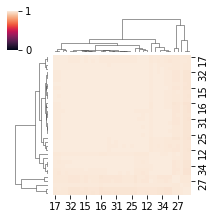

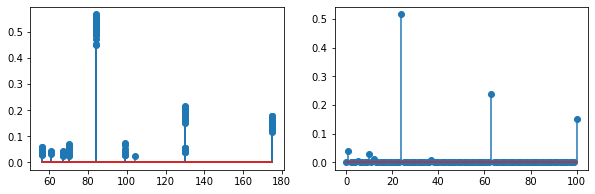

------------------------------
1.3136417691152946 - 3.719695347564052
2.1972245773362196 - 9.000000000000002
------------------------------
BIN ID 1612


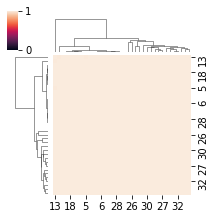

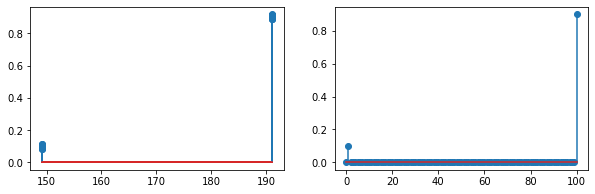

------------------------------
0.3223618122771328 - 1.3803841255401739
0.6931471805599453 - 2.0
------------------------------
BIN ID 1701


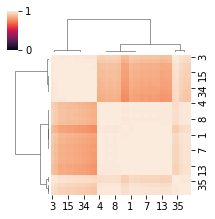

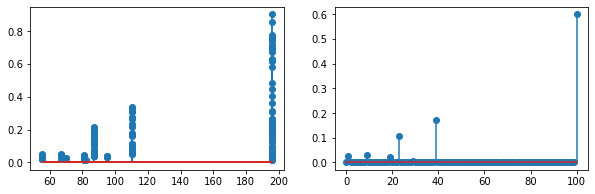

------------------------------
1.1685307033412482 - 3.2172620516789587
2.1972245773362196 - 9.000000000000002
------------------------------
BIN ID 2272


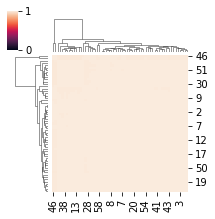

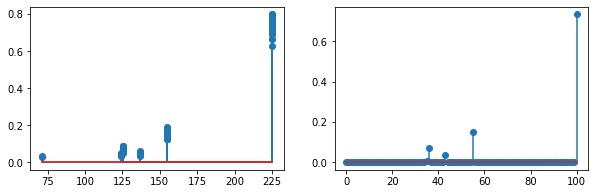

------------------------------
0.8649840276474366 - 2.374968151845516
1.791759469228055 - 6.0
------------------------------
BIN ID 2290


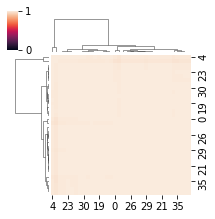

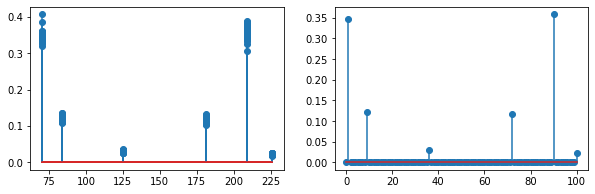

------------------------------
1.4350530058400577 - 4.199867620399364
1.7917594692280547 - 5.999999999999998
------------------------------
BIN ID 2293


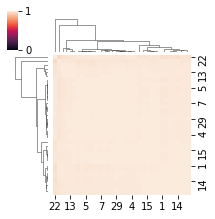

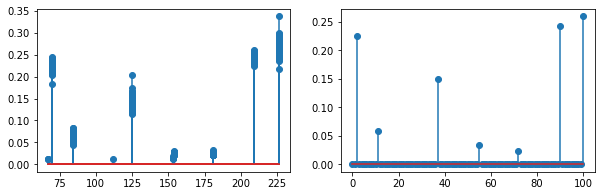

------------------------------
1.6945292120372 - 5.444082353360893
2.197224577336219 - 8.999999999999998
------------------------------
BIN ID 2337


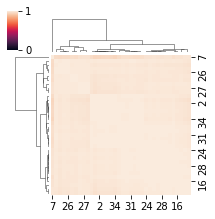

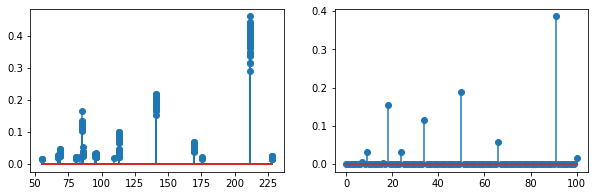

------------------------------
1.7513293465130255 - 5.7622576239187895
2.6390573296152584 - 13.999999999999996
------------------------------
BIN ID 2382


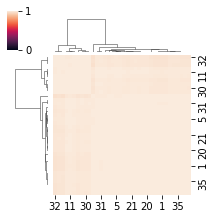

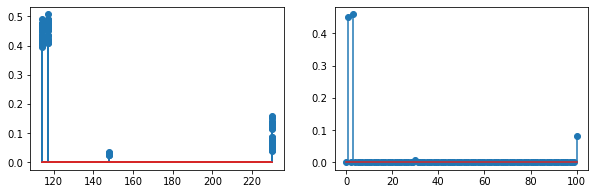

------------------------------
0.9586278939560458 - 2.6081154062707337
1.3862943611198906 - 4.0
------------------------------
BIN ID 2591


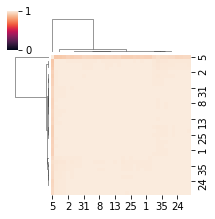

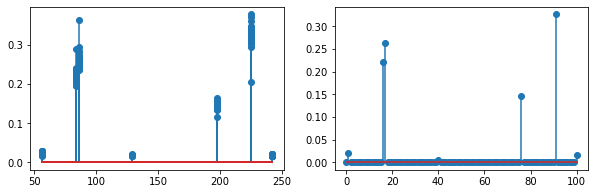

------------------------------
1.5091079527627738 - 4.522694537149198
1.945910149055313 - 6.999999999999998
------------------------------
BIN ID 2594


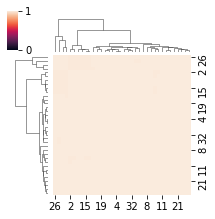

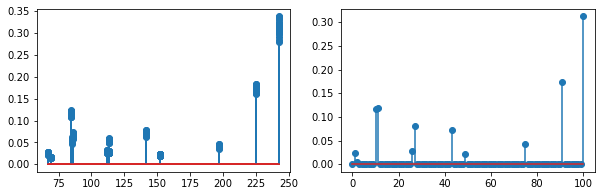

------------------------------
2.004223494882848 - 7.420329735086689
2.3978952727983707 - 11.000000000000002
------------------------------
BIN ID 2595


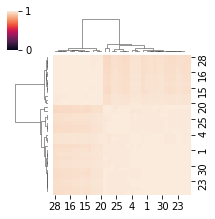

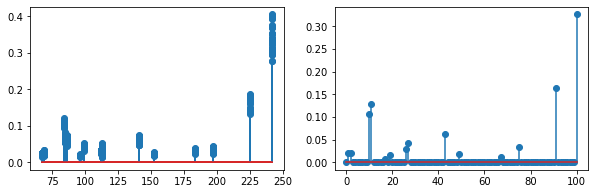

------------------------------
2.0955653621151913 - 8.130036085536071
2.6390573296152584 - 13.999999999999996
------------------------------
BIN ID 2637


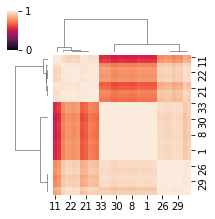

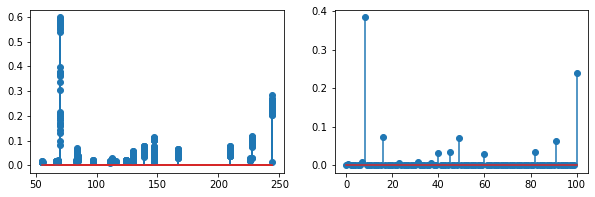

------------------------------
1.9070576792465963 - 6.733248248155073
2.833213344056216 - 17.0
------------------------------
BIN ID 2763


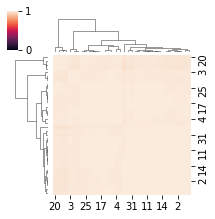

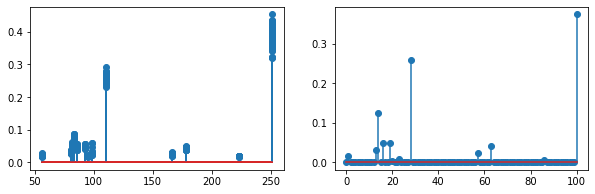

------------------------------
1.774079209308905 - 5.894850712899202
2.4849066497880004 - 12.0
------------------------------
BIN ID 3010


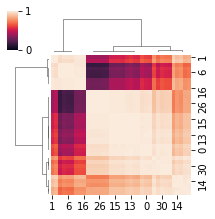

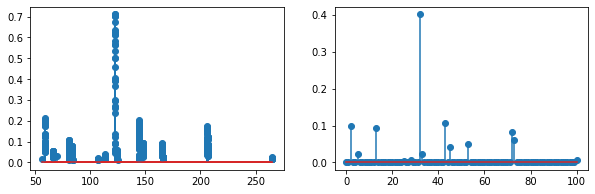

------------------------------
1.9874441196070902 - 7.29686000711076
2.833213344056216 - 17.0
------------------------------
BIN ID 3073


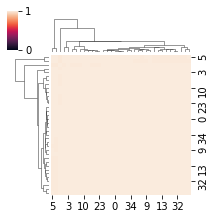

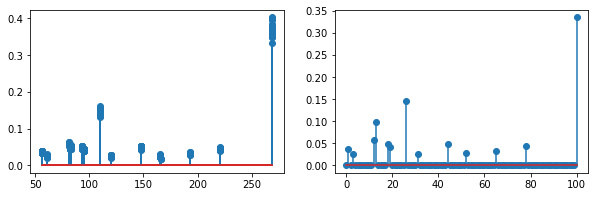

------------------------------
2.1596113368705394 - 8.667768161807107
2.564949357461537 - 13.000000000000005
------------------------------
BIN ID 3177


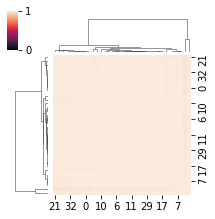

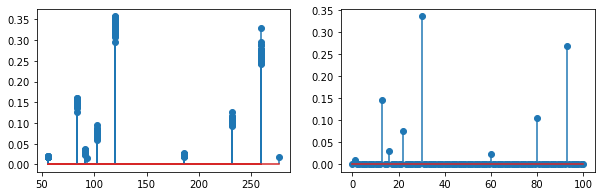

------------------------------
1.6807757653545075 - 5.369719998497298
2.197224577336219 - 8.999999999999998
------------------------------
BIN ID 3197


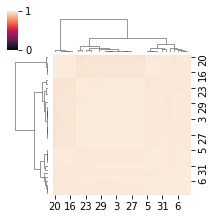

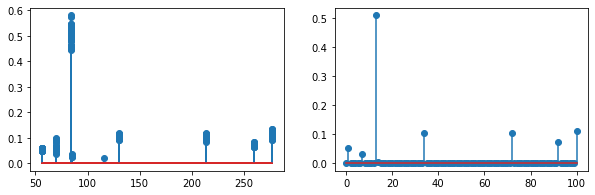

------------------------------
1.5594069821448164 - 4.756000015772233
2.197224577336219 - 8.999999999999998
------------------------------
BIN ID 3573


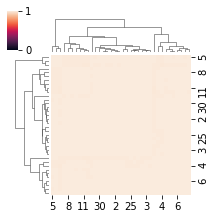

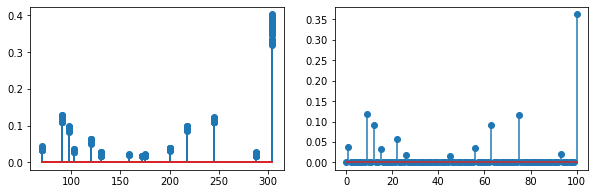

------------------------------
2.0604004990052633 - 7.849112742751454
2.6390573296152584 - 13.999999999999996
------------------------------
BIN ID 3779


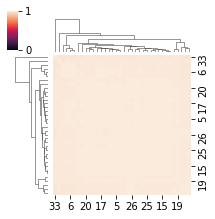

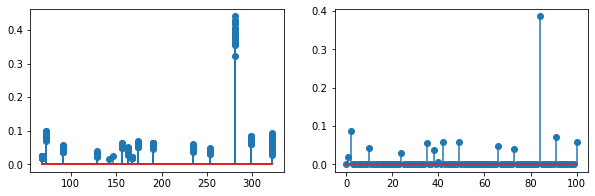

------------------------------
2.176484889858003 - 8.8152651063684
2.772588722239781 - 15.999999999999998
------------------------------
BIN ID 4049


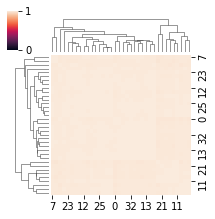

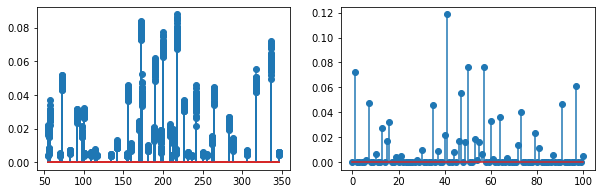

------------------------------
3.1799905727817093 - 24.04652685913812
3.6888794541139367 - 40.000000000000014
------------------------------
BIN ID 4684


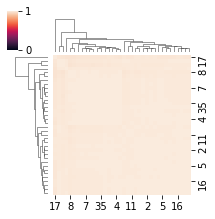

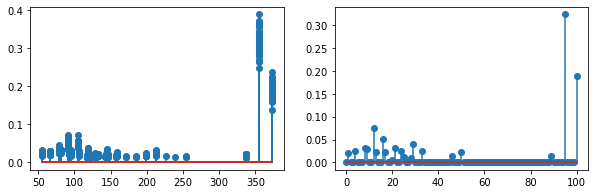

------------------------------
2.381384492948138 - 10.819872536063258
3.258096538021483 - 26.000000000000025
------------------------------
BIN ID 180


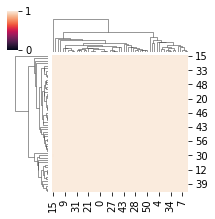

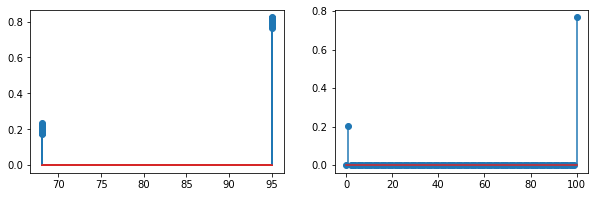

------------------------------
0.5134665508626883 - 1.6710740290275774
0.6931471805599453 - 2.0
------------------------------
BIN ID 188


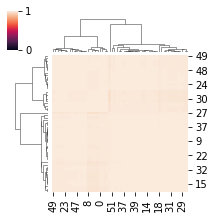

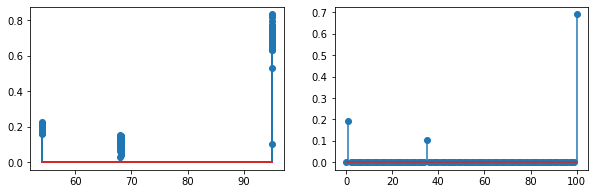

------------------------------
0.8048362275819225 - 2.2363302196199037
1.0986122886681096 - 2.9999999999999996
------------------------------
BIN ID 257


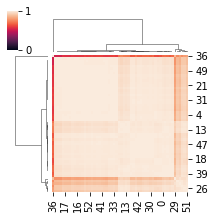

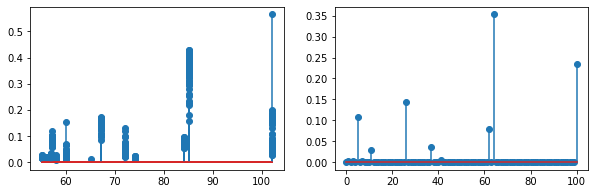

------------------------------
1.7383576965907017 - 5.687994335265387
2.484906649788001 - 12.000000000000005
------------------------------
BIN ID 278


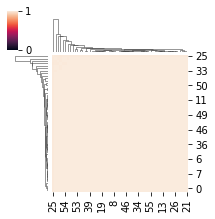

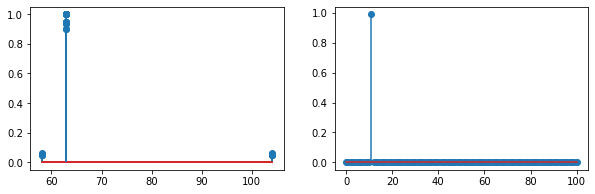

------------------------------
0.05581629956320577 - 1.0574034204238303
1.0986122886681096 - 2.9999999999999996
------------------------------
BIN ID 618


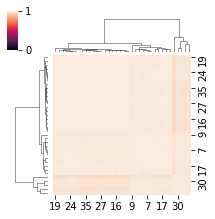

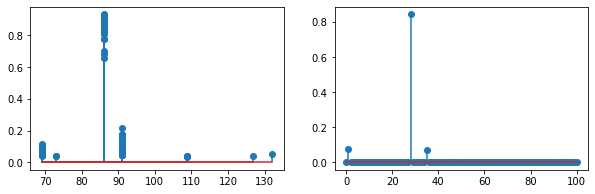

------------------------------
0.5655028038158285 - 1.760332662222471
1.791759469228055 - 6.0
------------------------------
BIN ID 919


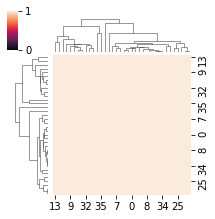

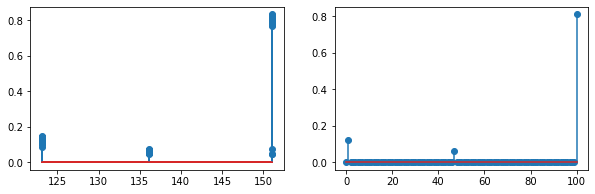

------------------------------
0.6012050986449142 - 1.8243159569170047
1.0986122886681096 - 2.9999999999999996
------------------------------
BIN ID 1092


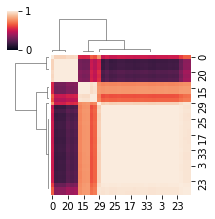

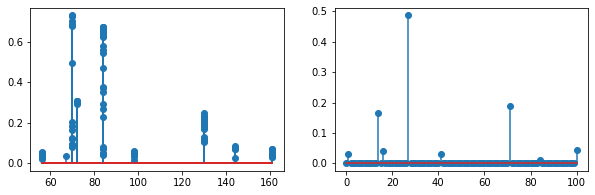

------------------------------
1.5049851904476117 - 4.504086926283261
2.197224577336219 - 8.999999999999998
------------------------------
BIN ID 1295


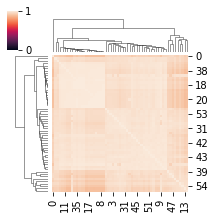

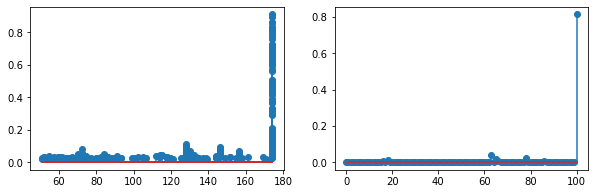

------------------------------
1.0464103338610922 - 2.847411494019087
4.1588830833596715 - 63.99999999999998
------------------------------
BIN ID 1597


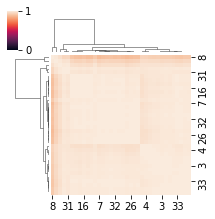

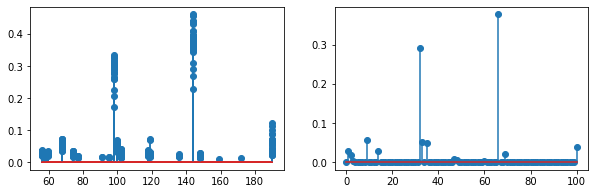

------------------------------
1.8394470164179795 - 6.293057341279183
2.9444389791664403 - 18.999999999999996
------------------------------
BIN ID 1704


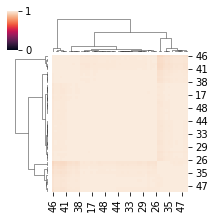

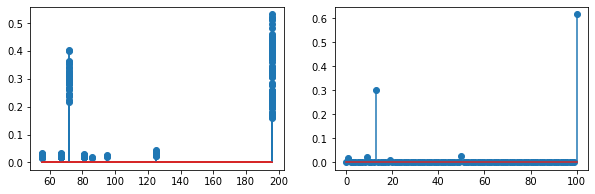

------------------------------
0.9802509292791122 - 2.665124915904861
2.0794415416798357 - 7.999999999999998
------------------------------
BIN ID 1727


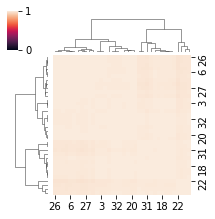

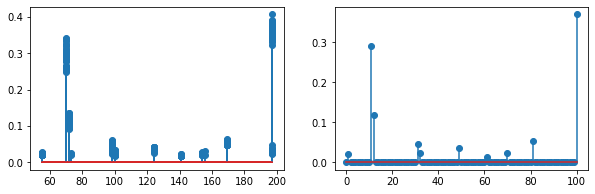

------------------------------
1.7358094717506538 - 5.673518498486818
2.484906649788001 - 12.000000000000005
------------------------------
BIN ID 2351


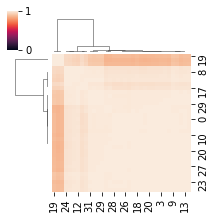

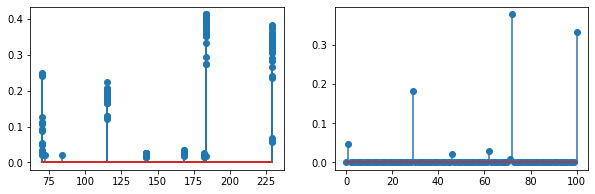

------------------------------
1.4185198303650108 - 4.131001329977248
2.1972245773362196 - 9.000000000000002
------------------------------
BIN ID 3024


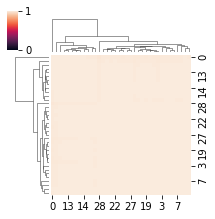

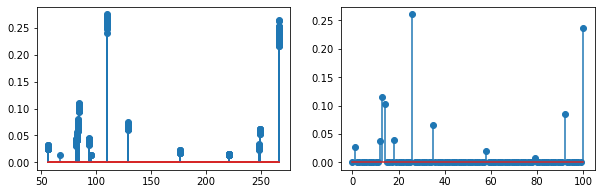

------------------------------
2.039931799107517 - 7.6900847103533945
2.564949357461537 - 13.000000000000005
------------------------------
BIN ID 3259


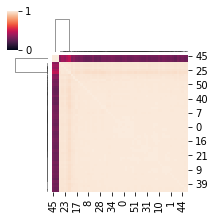

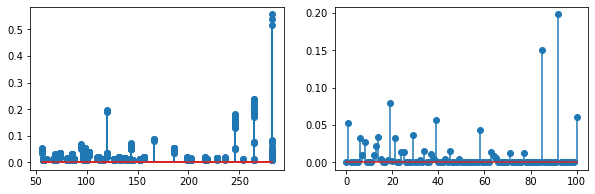

------------------------------
2.877383280686177 - 17.76771916288254
3.6635616461296454 - 38.99999999999996
------------------------------
BIN ID 3375


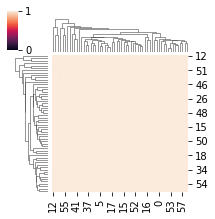

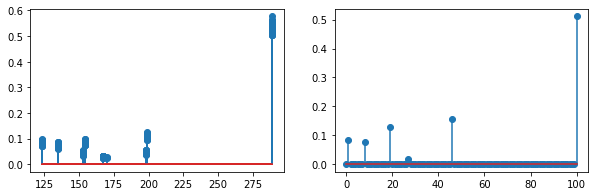

------------------------------
1.3968431427117696 - 4.0424184645781684
1.9459101490553132 - 6.999999999999999
------------------------------
BIN ID 4669


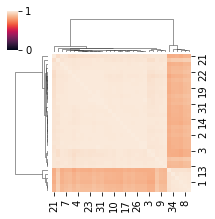

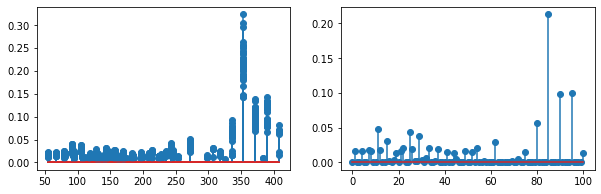

------------------------------
3.025834114927351 - 20.611189644047716
3.7612001156935624 - 43.0
------------------------------
BIN ID 5271


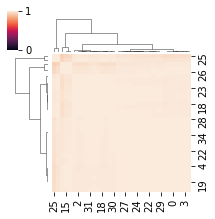

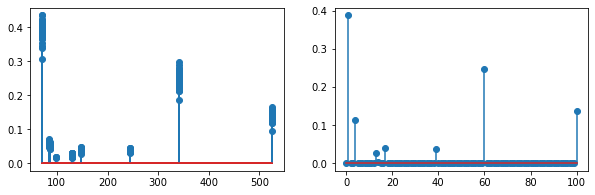

------------------------------
1.6204884031956825 - 5.055558864796902
2.1972245773362196 - 9.000000000000002
------------------------------
BIN ID 5480


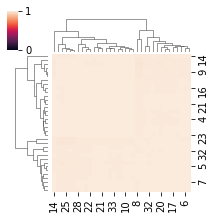

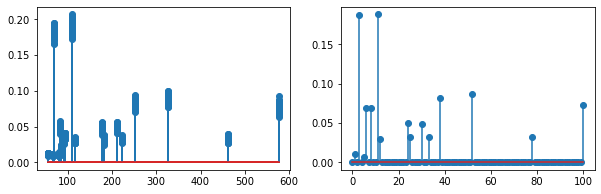

------------------------------
2.4246850446833035 - 11.298670282547395
2.70805020110221 - 15.0
------------------------------
BIN ID 5702


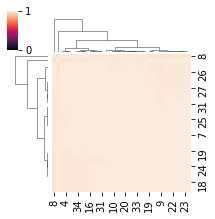

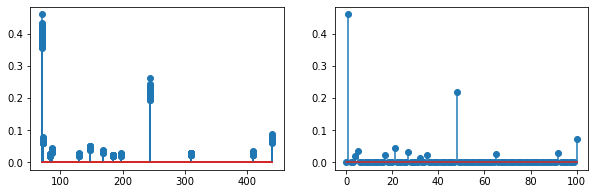

------------------------------
1.762149664894576 - 5.824945626458155
2.484906649788001 - 12.000000000000005
------------------------------
BIN ID 520


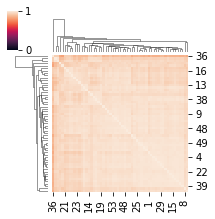

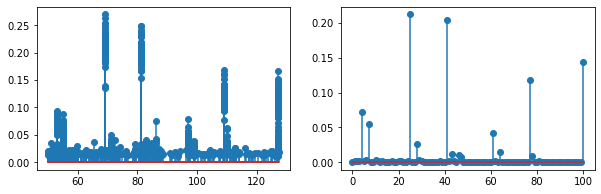

------------------------------
2.491245638782469 - 12.076309474867227
4.477336814478206 - 87.99999999999996
------------------------------
BIN ID 848


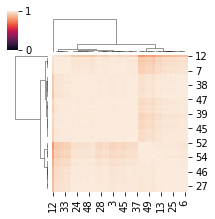

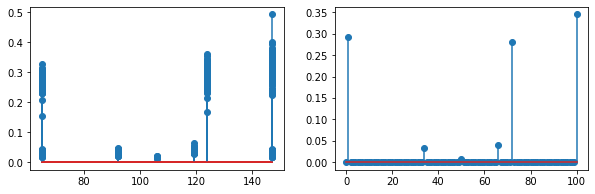

------------------------------
1.3636561452733487 - 3.9104644232689765
1.791759469228055 - 6.0
------------------------------
BIN ID 1840


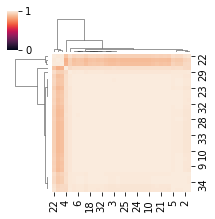

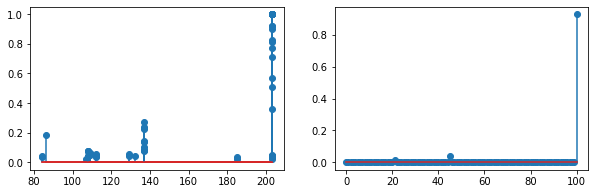

------------------------------
0.3559365485754668 - 1.4275169674050059
2.3025850929940455 - 9.999999999999998
------------------------------
BIN ID 1970


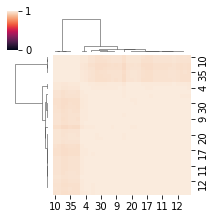

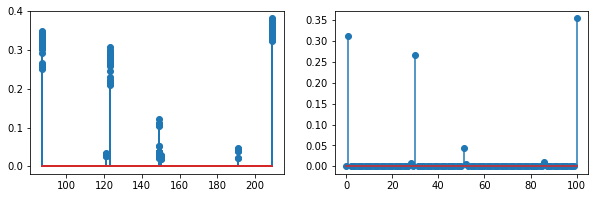

------------------------------
1.3315754540428975 - 3.787004942504934
1.9459101490553132 - 6.999999999999999
------------------------------
BIN ID 2281


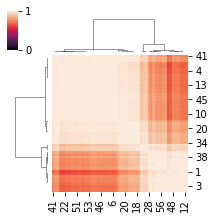

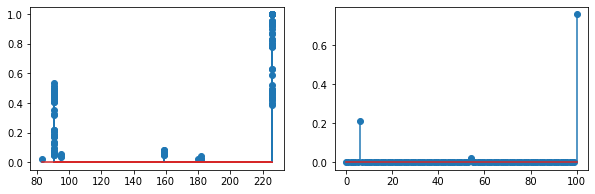

------------------------------
0.655516984090691 - 1.9261380427433743
1.9459101490553132 - 6.999999999999999
------------------------------
BIN ID 2987


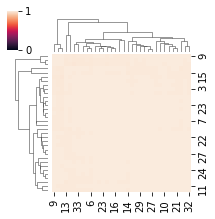

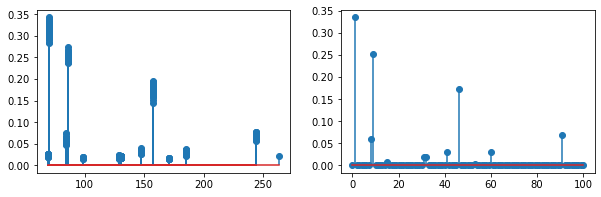

------------------------------
1.796526310774368 - 6.028669326057949
2.484906649788001 - 12.000000000000005
------------------------------
BIN ID 3533


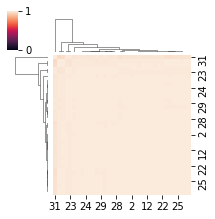

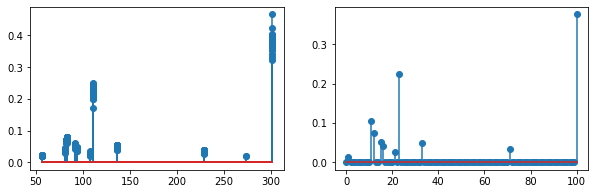

------------------------------
1.8479674748217367 - 6.34690615710878
2.3978952727983707 - 11.000000000000002
------------------------------
BIN ID 3587


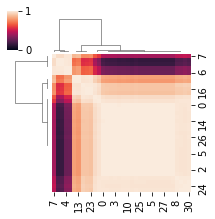

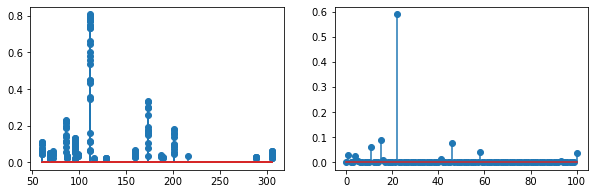

------------------------------
1.5820699798623798 - 4.865015880477681
2.833213344056216 - 17.0
------------------------------
BIN ID 5300


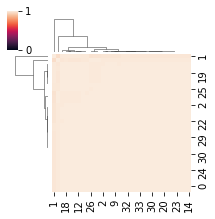

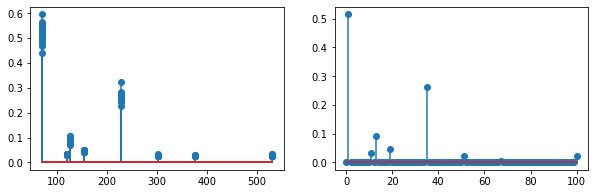

------------------------------
1.3636242563129264 - 3.910339724612016
2.0794415416798357 - 7.999999999999998
------------------------------
BIN ID 5764


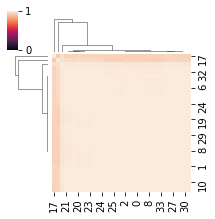

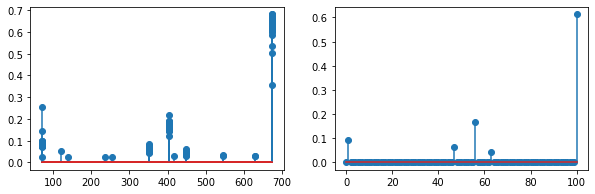

------------------------------
1.1769513144017882 - 3.2444677476328128
2.4849066497880004 - 12.0
------------------------------
BIN ID 110


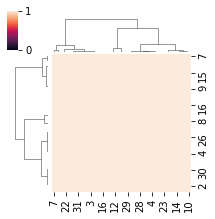

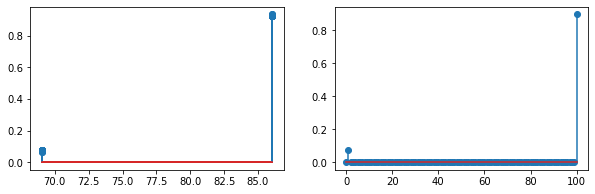

------------------------------
0.26867649851564296 - 1.308231857635924
0.6931471805599453 - 2.0
------------------------------


In [17]:
### starting_num=0
starting_num=500
ending_num=550
clusters_to_include=5



for i,temp_bin in enumerate(bin_ids_pop_desc):

    #print(temp_bin)
    if i<starting_num or i>ending_num:#i<80 or i>100: #or i<2:
        continue
    #if i<500 or i>511:
    #    continue
    print(f'BIN ID {temp_bin}')
    #print(f'i is {i}')
    get_spectrum_sample_query=f'''
    select spectrum from runs r
    inner join annotations a
    on r.run_id=a.run_id
    where (run_type="Sample") and (bin_id={temp_bin}) and (spectrum is not null)
    '''
    
    input_spectra_list=execute_query(database_address,get_spectrum_sample_query)

    input_spectra_list=[temp_tup[0] for temp_tup in input_spectra_list]

    all_spectrum_list=[
        parse_one_ms_dial_spectrum(temp_spectrum) for temp_spectrum in input_spectra_list
    ]
    
    all_spectrum_list_yuanyue=make_spectra_like_similarity_metric_expects(
        all_spectrum_list
    )
    #print(all_spectrum_list_yuanyue)
    #hold=input('hold')
    all_spectrum_list_yuanyue_cleaned=[
        spectral_entropy.tools.clean_spectrum(
            temp_spectrum,
            noise_removal=0.05,
            ms2_da=0.015
        ) for temp_spectrum in all_spectrum_list_yuanyue
    ]
    all_spectrum_list_cleaned=make_spectra_like_head_to_tails_expects(
        all_spectrum_list_yuanyue_cleaned
    )
    
    #generate the similarity matrix
    similarity_matrix,distance_matrix_flattened=make_distance_matrix(all_spectrum_list_yuanyue)
    
    #generate the linkage matrix
    row_linkage=hierarchy.linkage(
        distance_matrix_flattened,method='average'
    )
    
    #print(row_linkage)
    #hold=input('hold')
    #generate the linkage matrix
    column_linkage=row_linkage
    
    #make the heatmap
    sns.clustermap(
        similarity_matrix,
        row_linkage=row_linkage,
        col_linkage=column_linkage,
        vmin=0,
        vmax=1,
        figsize=(3,3),
    )
    plt.show()
    
    
    fix,ax=plt.subplots(
        #nrows=(ending_num-starting_num)+1,
        nrows=1,
        ncols=2,
        figsize=(10,3)
    )
    plot_some_head_to_tails(all_spectrum_list_cleaned,ax[0])
    #hold=input('hold')
    intensity_list,group_entropy=generate_entropy_metric(all_spectrum_list_cleaned,0.015)
    #print(intensity_list)
    ax[1].stem(
        range(len(intensity_list)),
        intensity_list
    )
    plt.show()
    print('-'*30)
    #print(np.ceil(intensity_list))
    print(str(entropy(intensity_list))+' - '+str(math.exp(entropy(intensity_list))))
    print(str(entropy(np.ceil(intensity_list)))+' - '+str(math.exp(entropy(np.ceil(intensity_list)))))
    print('-'*30)

In [18]:
entropy([0 for i in range(100)]+[0.01])

0.0

In [19]:
entropy([1 for i in range(100)]+[0.01])

4.605730651959928

In [20]:
entropy([1 for i in range(10)])

2.3025850929940455